In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import torchvision, torch
import sys, os
sys.path.insert(0,"../torchxrayvision/")
import torchxrayvision as xrv
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import glob
import numpy as np
import skimage, skimage.filters
%matplotlib inline
import captum, captum.attr
import torch, torch.nn
import pickle
import attribution
import pandas as pd
import datasets
import shutil
import json
import glob
import seaborn
import scipy
import gzip

In [3]:
def full_frame(width=None, height=None):
    import matplotlib as mpl
    mpl.rcParams['savefig.pad_inches'] = 0
    figsize = None if width is None else (width, height)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)

In [36]:
with gzip.open("trial_record.json.gz", 'r') as fin: 
    record = json.load(fin)

In [37]:
df = pd.DataFrame(record)
df.index += 1 
df.head()

,id,idx,dataset,source,target,label,model_used,pred,attribs,trialid,trial
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0
2,NIH_Dataset-5015520986-Cardiomegaly-1,50155,NIH_Dataset,"{'index': 85137, 'Image Index': '00020986_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.610710,{'image': 'images/NIH_Dataset-5015520986-Cardi...,2,0
3,NIH_Dataset-6417228873-Cardiomegaly-1,64172,NIH_Dataset,"{'index': 106971, 'Image Index': '00028873_009...",Cardiomegaly,1,XRV-DenseNet121-all,0.685441,{'image': 'images/NIH_Dataset-6417228873-Cardi...,3,0
4,NIH_Dataset-638248-Cardiomegaly-0,638,NIH_Dataset,"{'index': 1025, 'Image Index': '00000248_022.p...",Cardiomegaly,0,XRV-DenseNet121-all,0.605365,{'image': 'images/NIH_Dataset-638248-Cardiomeg...,4,0
5,NIH_Dataset-108404381-Cardiomegaly-1,10840,NIH_Dataset,"{'index': 16454, 'Image Index': '00004381_021....",Cardiomegaly,1,XRV-DenseNet121-all,0.636316,{'image': 'images/NIH_Dataset-108404381-Cardio...,5,0


In [7]:
for_eval = {
            "Cardiomegaly":datasets.get_data("nih"),
            'Mass':datasets.get_data("nih"),
            "Atelectasis":datasets.get_data("nih"),
            "Effusion":datasets.get_data("nih"),
            "Lung Opacity":datasets.get_data("rsna"),
            "Pneumothorax":datasets.get_data("siim"),
            }

NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
NIH_Dataset num_samples=67310 views=['PA'] data_aug=None
RSNA_Pneumonia_Dataset num_samples=14511 views=['PA'] data_aug=None
SIIM_Pneumothorax_Dataset num_samples=12954 data_aug=None


In [9]:
model = xrv.models.DenseNet(weights="all").cuda()
ae = xrv.autoencoders.ResNetAE(weights="101-elastic").cuda()

In [ ]:
ious = []
for i, row in df[df.label == 1].iterrows():
    target = row.target
    dmerge = for_eval[target]
    sample = dmerge[int(row.idx)]
    iou = {}
    iou["Example"] = row.trialid
    for method in ["latentshift-max", "integrated", "guided", "grad"]:
        
        image = torch.from_numpy(sample["img"]).unsqueeze(0).cuda()

        dimage = attribution.compute_attribution(image, method, model, target, ae=ae)
        thisiou = attribution.calc_iou(dimage, sample["pathology_masks"][dmerge.pathologies.index(target)][0])["iou"]
        iou[method + "_iou"] = thisiou
    ious.append(iou)
    
    

In [11]:
ious_df = pd.DataFrame(ious).set_index("Example")

In [12]:
ious_df

,latentshift-max_iou,integrated_iou,guided_iou,grad_iou
Example,,,,
1,0.292375,0.233397,0.185915,0.309032
2,0.246111,0.296602,0.235799,0.308383
3,0.223418,0.202797,0.313491,0.358582
5,0.394668,0.193175,0.255957,0.339881
10,0.290807,0.363214,0.312200,0.249890
...,...,...,...,...
230,0.029843,0.002956,0.005432,0.012935
231,0.028571,0.044275,0.000000,0.002933
232,0.000000,0.000000,0.009957,0.000000


In [13]:
#ious_df.to_csv("trial_ious.csv")

In [38]:
ious_df = pd.read_csv("trial_ious.csv").set_index("Example")

In [39]:
df = df.join(ious_df)

In [40]:
reads =  [['reader-results/read0-reader1.csv',0, 1],
         [ 'reader-results/read1-reader1.csv',1, 1],
         [ 'reader-results/read0-reader2.csv',0, 2],
         [ 'reader-results/read1-reader2.csv',1, 2]]

In [41]:
results_list = []
for fname, read, reader in reads:
    results = pd.read_csv(fname)
    results["read"] = read
    results["reader"] = reader
    results_list.append(results.set_index("Example"))

In [42]:
results = pd.concat(results_list)

In [43]:
results

,How confident are you in the models prediction? (1-5),Is the model looking at the correct feature? (1-5),read,reader
Example,,,,
1,4,3,0,1
2,4,3,0,1
3,5,4,0,1
4,3,2,0,1
5,5,3,0,1
...,...,...,...,...
236,1,1,1,2
237,1,1,1,2
238,1,1,1,2


In [44]:
results.columns = ["confident","features", "read", "reader"]

In [45]:
dd = df.join(results)
dd.head()

,id,idx,dataset,source,target,label,model_used,pred,attribs,trialid,trial,latentshift-max_iou,integrated_iou,guided_iou,grad_iou,confident,features,read,reader
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,0.292375,0.233397,0.185915,0.309032,4,3,0,1
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,0.292375,0.233397,0.185915,0.309032,4,5,1,1
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,0.292375,0.233397,0.185915,0.309032,4,4,0,2
1,NIH_Dataset-4069616990-Cardiomegaly-1,40696,NIH_Dataset,"{'index': 68896, 'Image Index': '00016990_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.638716,{'image': 'images/NIH_Dataset-4069616990-Cardi...,1,0,0.292375,0.233397,0.185915,0.309032,5,5,1,2
2,NIH_Dataset-5015520986-Cardiomegaly-1,50155,NIH_Dataset,"{'index': 85137, 'Image Index': '00020986_000....",Cardiomegaly,1,XRV-DenseNet121-all,0.610710,{'image': 'images/NIH_Dataset-5015520986-Cardi...,2,0,0.246111,0.296602,0.235799,0.308383,4,3,0,1


In [46]:
dd.to_csv("trial_results.csv")

In [47]:
dd = pd.read_csv("trial_results.csv")

In [48]:
# adjust for second read
dd["trial"][dd["read"] == 1] = np.abs(dd["trial"][dd["read"] == 1]-1)

In [49]:
dd["label"][dd.label == 0] = "False Positive"
dd["label"][dd.label == 1] = "True Positive"
dd["trial"][dd.trial == 0] = "Traditional"
dd["trial"][dd.trial == 1] = "Latent Shift"

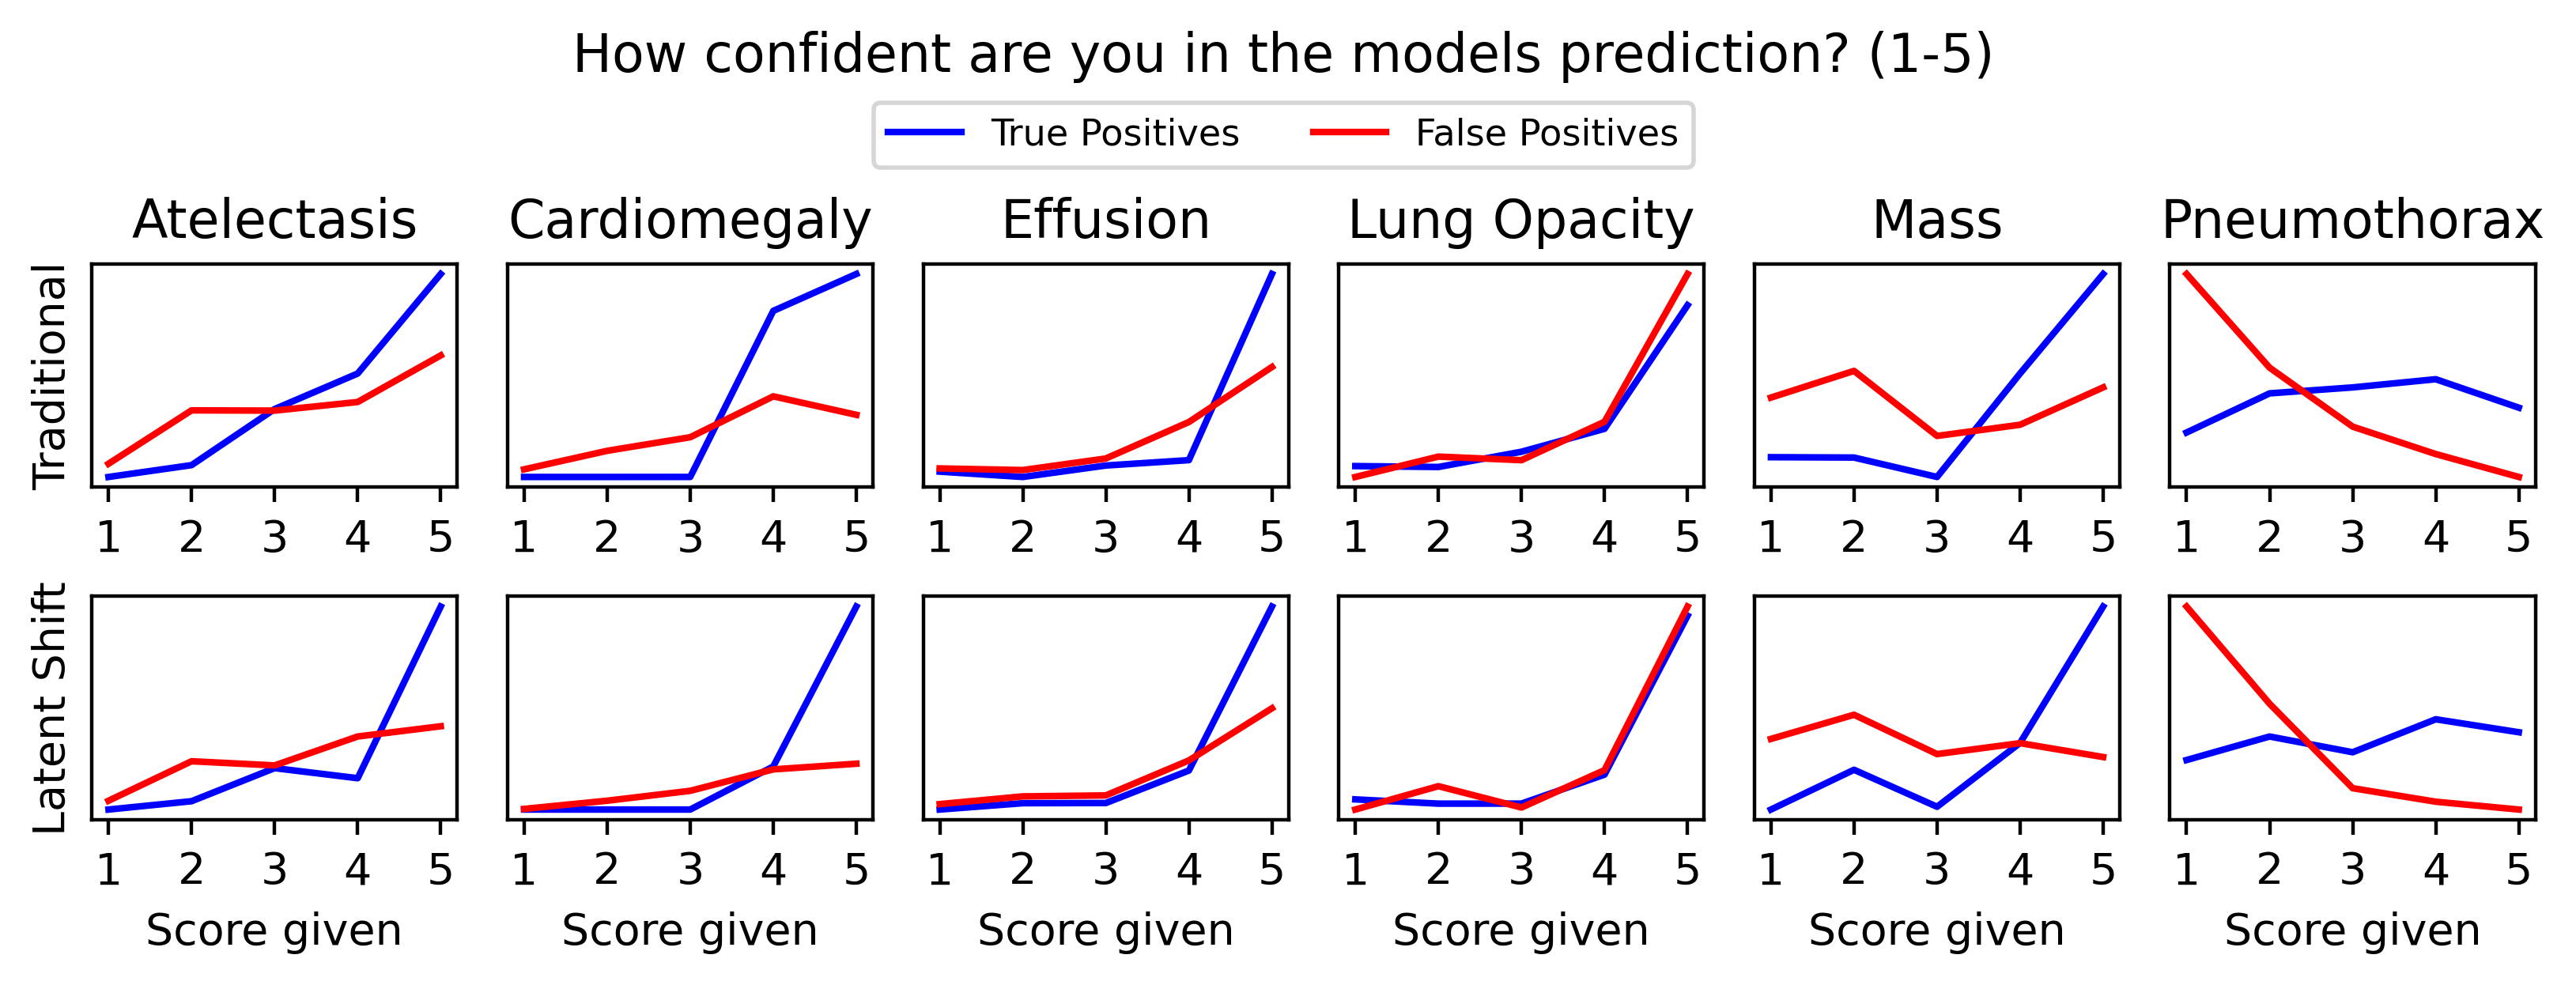

In [50]:
fig, ax = plt.subplots(2,len(dd["target"].unique()), figsize=(8,3), dpi=400, constrained_layout=True, facecolor='w')
fig.suptitle('How confident are you in the models prediction? (1-5)\n', fontsize=12)

#fig.text(-0.01, 0.5,'How confident are you in the models prediction?', fontsize=10, ha='center', va='center', rotation='vertical')


for i, (target, group) in enumerate(dd[dd["trial"] == "Traditional"].groupby("target")):
    for name, color, in [("True Positive", "blue"), ("False Positive", "red")]:
        group[group["label"] == name]["confident"].plot.kde(ax=ax[0,i], ind=np.arange(1,5.1,1), c=color, label=name)
    ax[0,i].set_xticks(range(1,6))
    ax[0,i].set_yticks([])
    #ax[0,i].set_xlabel("Score given");
    ax[0,i].set_ylabel("");
    ax[0,i].set_title(target);
    
#ax[0,3].legend(prop={'size': 9});
ax[0,0].set_ylabel("Traditional");

for i, (target, group) in enumerate(dd[dd["trial"] == "Latent Shift"].groupby("target")):
    for name, color, in [("True Positive", "blue"), ("False Positive", "red")]:
        this = group[group["label"] == name]["confident"].plot.kde(ax=ax[1,i], ind=np.arange(1,5.1,1), c=color, label=name)
    ax[1,i].set_xticks(range(1,6))
    ax[1,i].set_yticks([])
    ax[1,i].set_xlabel("Score given");
    ax[1,i].set_ylabel("");
    
ax[1,0].set_ylabel("Latent Shift");

#plt.legend(ncol=2, bbox_to_anchor=(0.5, 1.1), loc='upper center');
handles, labels = ax[0,0].get_legend_handles_labels()
labels = ["True Positives", "False Positives"]
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.93),fontsize="small");


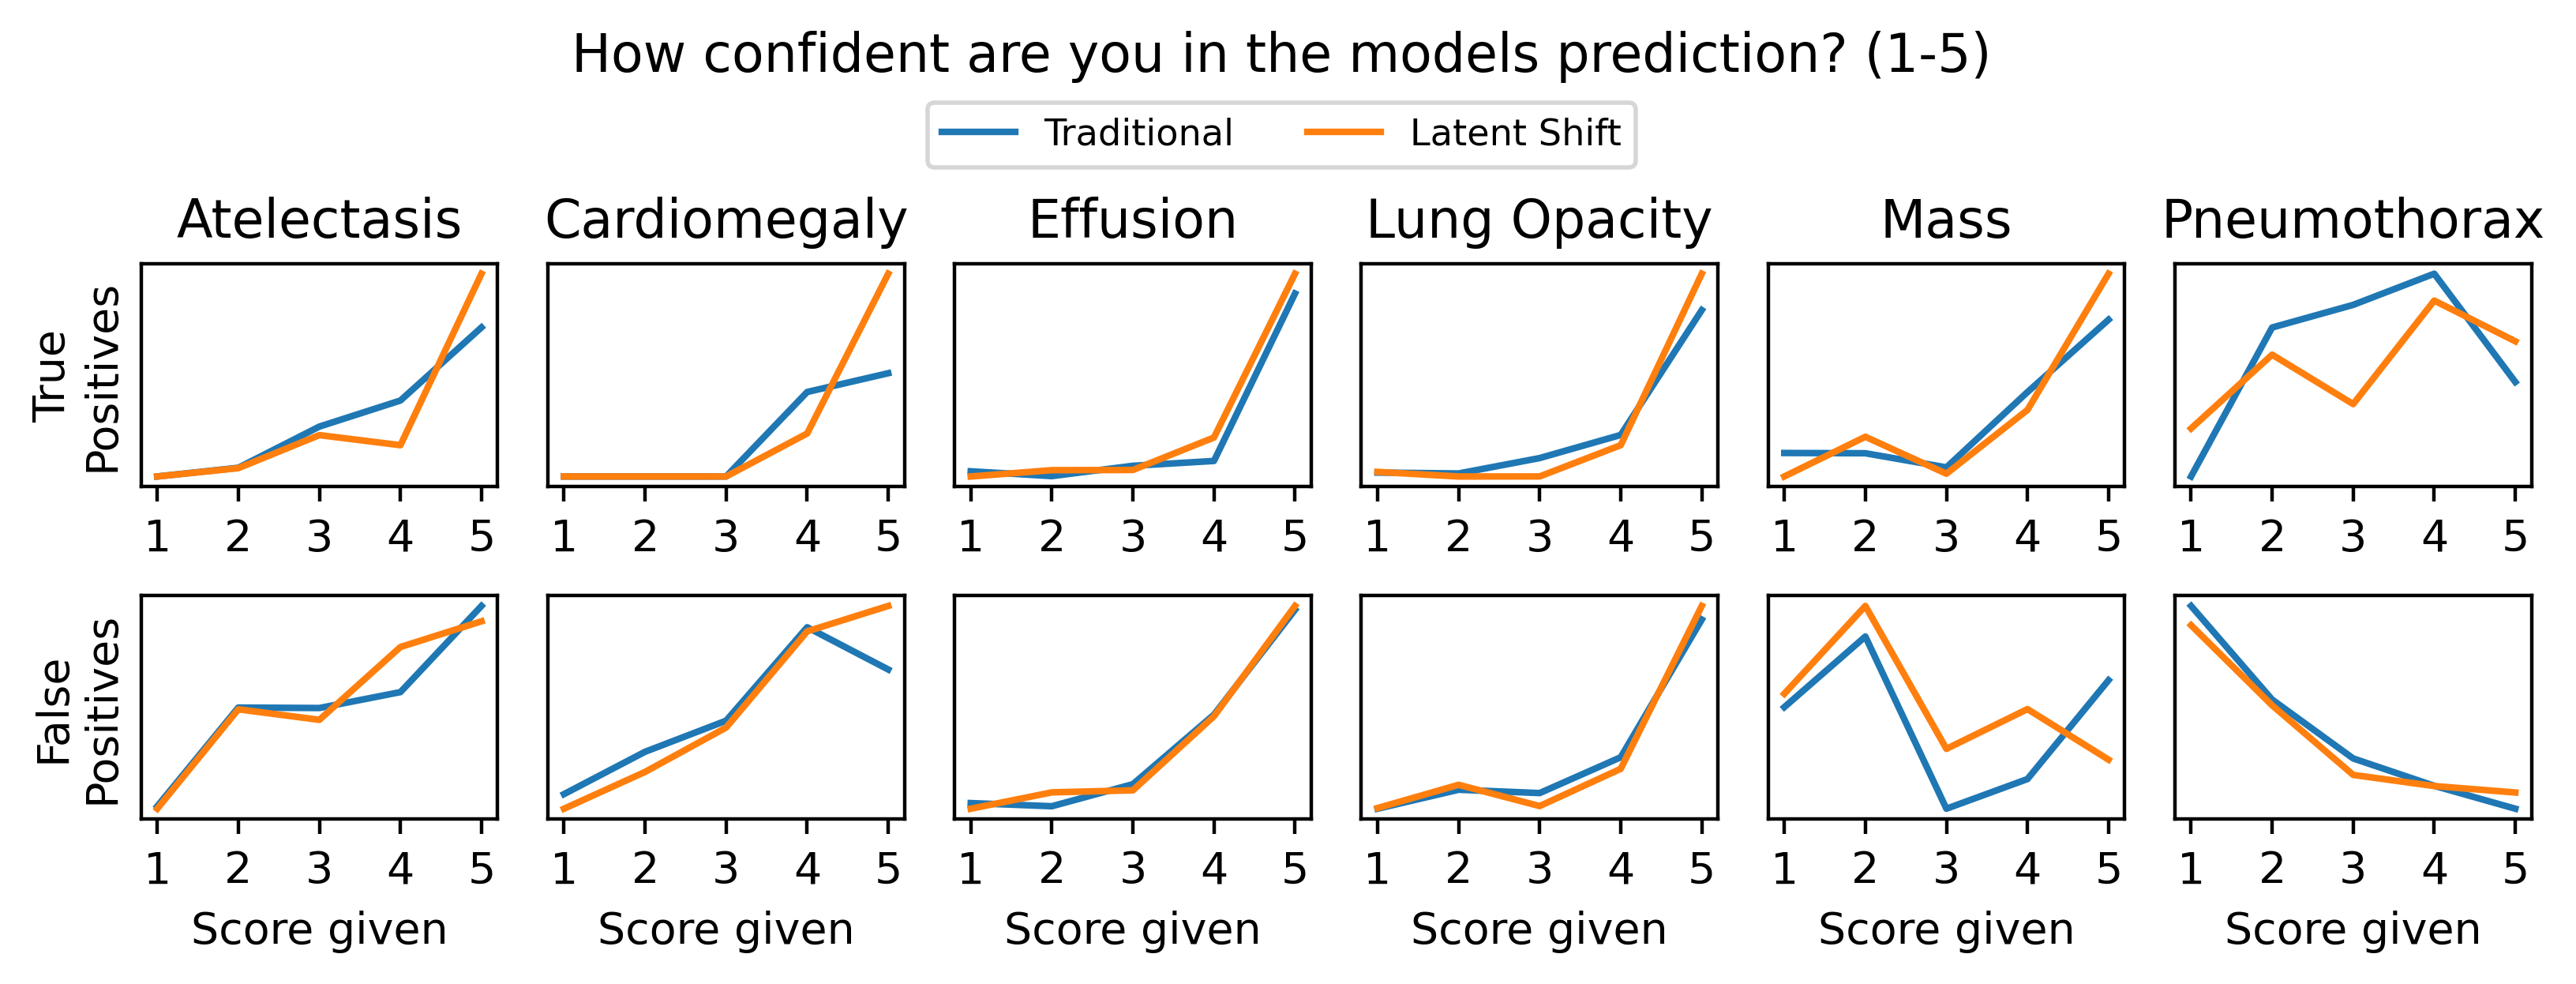

In [51]:
fig, ax = plt.subplots(2,len(dd["target"].unique()), figsize=(8,3), dpi=400, constrained_layout=True, facecolor='w')
fig.suptitle('How confident are you in the models prediction? (1-5)\n', fontsize=12)
for i, (name, group) in enumerate(dd[dd["label"] == "True Positive"].groupby("target")):
    group.groupby("trial", sort=False)["confident"].plot.kde(ax=ax[0,i], ind=np.arange(1,5.1,1))
    ax[0,i].set_xticks(range(1,6))
    ax[0,i].set_yticks([])
    #ax[0,i].set_xlabel("Score given");
    ax[0,i].set_ylabel("");
    ax[0,i].set_title(name);
    
#ax[0,0].set_yticks([0,5,10,15])
#ax[0,1].legend(prop={'size': 9});
ax[0,0].set_ylabel("True\nPositives");

for i, (name, group) in enumerate(dd[dd["label"] == "False Positive"].groupby("target")):
    group.groupby("trial", sort=False)["confident"].plot.kde(ax=ax[1,i], ind=np.arange(1,5.1,1))
    ax[1,i].set_xticks(range(1,6))
    ax[1,i].set_yticks([])
    ax[1,i].set_xlabel("Score given");
    ax[1,i].set_ylabel("");
    #ax[1,i].set_title(name);

#ax[1,0].set_yticks([0,5,10,15])
#ax[1,2].legend(prop={'size': 9});
ax[1,0].set_ylabel("False\nPositives");

handles, labels = ax[0,0].get_legend_handles_labels()
#labels = ["True Positives", "False Positives"]
fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.93),fontsize="small");


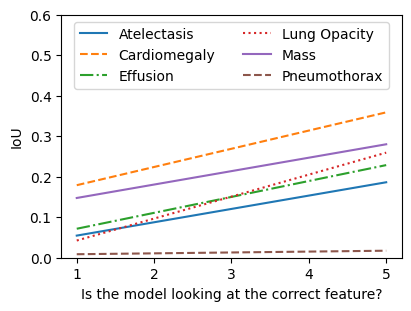

In [52]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=100, constrained_layout=True, facecolor='w')
select = (dd.label == "True Positive") & (dd.trial == "Latent Shift")
ls = ['-', '--', '-.', ':','-', '--', '-.', ':'];
for i, (name, group) in enumerate(dd[select].groupby("target")):
    x, y = group["features"], group["latentshift-max_iou"]
    #ax.scatter(x, y, alpha=0.5)
    m, b = np.polyfit(x, y, 1)
    ax.plot(range(1,6), m*range(1,6) + b, label=name, linestyle=ls[i])
    ax.set_xticks(range(1,6))
    
ax.set_xlabel("Is the model looking at the correct feature?");
ax.set_ylabel("IoU");
ax.set_ylim(0,0.6)
ax.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='upper center');

In [53]:
print(dd.groupby(["trial"])["confident"].mean())
print(dd.groupby(["trial"])["confident"].std())
print(dd.groupby(["trial"])["confident"].count())

trial
Latent Shift    3.966667
Traditional     3.868750
Name: confident, dtype: float64
trial
Latent Shift    1.389993
Traditional     1.389441
Name: confident, dtype: float64
trial
Latent Shift    480
Traditional     480
Name: confident, dtype: int64


In [91]:
import scipy.stats
scipy.stats.ttest_ind_from_stats(3.966667, 3.868750, 480, 3.868750, 1.389441, 480)

Ttest_indResult(statistic=0.5218719849425445, pvalue=0.6018801002667269)

In [102]:
scipy.stats.ttest_ind(dd[dd["trial"] == "Traditional"]["confident"], 
                      dd[dd["trial"] == "Latent Shift"]["confident"])

Ttest_indResult(statistic=-1.0915305671111868, pvalue=0.2753139264768074)

In [103]:
scipy.stats.ttest_rel(dd[dd["trial"] == "Traditional"]["confident"], 
                      dd[dd["trial"] == "Latent Shift"]["confident"])

Ttest_relResult(statistic=-2.1201700129885865, pvalue=0.034505174242763954)

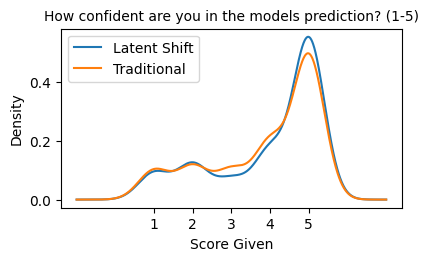

In [115]:
fig, ax = plt.subplots(1,1, figsize=(4,2.5), dpi=100, constrained_layout=True, facecolor='w')
ax.set_title('How confident are you in the models prediction? (1-5)', fontsize=10)
dd.groupby(["trial"])["confident"].plot.kde(ax=ax)
ax.legend();
ax.set_xticks(range(1,6));
ax.set_xlabel("Score Given");

In [82]:
selecta = (dd.label == "True Positive") & (dd["trial"] == "Latent Shift")
selectb = (dd.label == "True Positive") & (dd["trial"] == "Traditional")
diff = dd[selecta]["confident"].values - dd[selectb]["confident"].values
print(diff.mean())
print(scipy.stats.wilcoxon(diff))

0.15
WilcoxonResult(statistic=1233.5, pvalue=0.010369663537075838)


In [83]:
diff.std()

0.9543758868146939

In [80]:
selecta = (dd.label == "False Positive") & (dd["trial"] == "Latent Shift")
selectb = (dd.label == "False Positive") & (dd["trial"] == "Traditional")
diff = dd[selecta]["confident"].values - dd[selectb]["confident"].values
print(diff.mean())
print(scipy.stats.wilcoxon(diff))

0.04583333333333333
WilcoxonResult(statistic=2822.5, pvalue=0.5793095185489971)


In [81]:
diff.std()

1.061633633709022

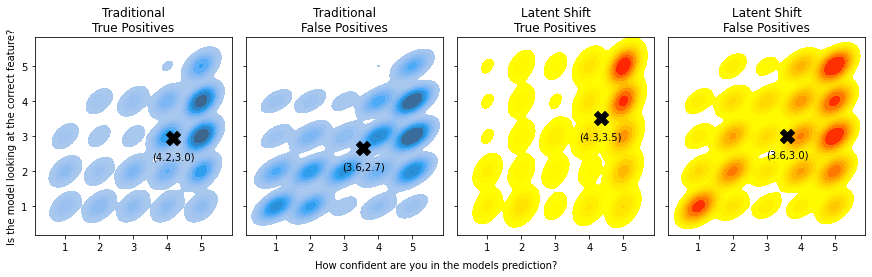

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(12, 3.5), sharey=True, sharex=True,constrained_layout=True, facecolor='w')

subset = dd[(dd.label == "True Positive") & (dd.trial == "Traditional")]
seaborn.kdeplot(subset["confident"], subset["features"], ax=ax[0], shade=True, legend=True, 
                cbar=False,bw_adjust=0.5).set_title("Traditional\nTrue Positives")
x = subset["confident"].mean()
y = subset["features"].mean()
ax[0].scatter(x,y,c="black", marker="X",s=200) 
ax[0].text(x,y-0.4,"({:.1f},{:.1f})".format(x,y),horizontalalignment='center',verticalalignment='top')


subset = dd[(dd.label == "False Positive") & (dd.trial == "Traditional")]
seaborn.kdeplot(subset["confident"], subset["features"], ax=ax[1], shade=True, legend=True, common_norm=0.1, 
                cbar=False,bw_adjust=0.5).set_title("Traditional\nFalse Positives")
x = subset["confident"].mean()
y = subset["features"].mean()
ax[1].scatter(x,y,c="black", marker="X",s=200) 
ax[1].text(x,y-0.4,"({:.1f},{:.1f})".format(x,y),horizontalalignment='center',verticalalignment='top')



subset = dd[(dd.label == "True Positive") & (dd.trial == "Latent Shift")]
seaborn.kdeplot(subset["confident"], subset["features"], ax=ax[2], shade=True, legend=True, 
                cbar=False, bw_adjust=0.5, cmap="autumn_r").set_title("Latent Shift\nTrue Positives")
x = subset["confident"].mean()
y = subset["features"].mean()
ax[2].scatter(x,y,c="black", marker="X",s=200) 
ax[2].text(x,y-0.4,"({:.1f},{:.1f})".format(x,y),horizontalalignment='center',verticalalignment='top')

subset = dd[(dd.label == "False Positive") & (dd.trial == "Latent Shift")]
seaborn.kdeplot(subset["confident"], subset["features"], ax=ax[3], shade=True, legend=True, 
                cbar=False,bw_adjust=0.5, cmap="autumn_r").set_title("Latent Shift\nFalse Positives")
x = subset["confident"].mean()
y = subset["features"].mean()
ax[3].scatter(x,y,c="black", marker="X",s=200) 
ax[3].text(x,y-0.4,"({:.1f},{:.1f})".format(x,y),horizontalalignment='center',verticalalignment='top')


ax[0].set_yticks(range(1,6))
ax[0].set_xticks(range(1,6))
for a in ax:
    a.set_xlabel("");
    
ax[0].set_ylabel("Is the model looking at the correct feature?")
fig.text(0.5, -0.05, 'How confident are you in the models prediction?', ha='center');
